Скачиваем библиотеку через командную строку

In [ ]:
!pip install ipykernel

Клонируем библиотеку 

In [ ]:
# !git clone  


Устанавливаем биботеки

In [ ]:
!pip install requests
!pip install pandas
!pip install tqdm
!pip install numpy

Импортируем биботеки

In [ ]:
import json
import requests
import hashlib
import pandas as pd
from datetime import datetime
from urllib.parse import urlsplit
import numpy as np
from tqdm.notebook import tqdm

Добавляем эмуляцию активности с другого устройства чтобы не забанило

In [ ]:
class DomClickApi:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({"X-Service": "true",
                                     "Connection": "Keep-Alive",
                                     "User-Agent": "Android; 12; Google; google_pixel_5; 8.72.0; 8720006; ; NONAUTH"
                                     })

        # Инициализация (получение cookies)
        self.get("https://api.domclick.ru/core/no-auth-zone/api/v1/ensure_session")
        self.get("https://ipoteka.domclick.ru/mobile/v1/feature_toggles")

    def get(self, url, **kwargs):
        self.__update_headers(url, **kwargs)
        result = self.session.get(url, **kwargs)
        print(self.session.cookies.get_dict())
        return result

    def __update_headers(self, url, **kwargs):
        url = self.__get_prepared_url(url, **kwargs)
        sault = "ad65f331b02b90d868cbdd660d82aba0"
        timestamp = str(int(datetime.now().timestamp()))
        encoded = (sault + url + timestamp).encode("UTF-8")
        h = hashlib.md5(encoded).hexdigest()
        self.session.headers.update({"Timestamp": timestamp,
                                     "Hash": "v1:" + h,
                                     })

    def __get_prepared_url(self, url, **kwargs):
        p = requests.models.PreparedRequest()
        p.prepare(method="GET", url=url, **kwargs)
        return p.url


def pprint_json(json_str):
    try:
        json_object = json.loads(json_str)
        json_formatted_str = json.dumps(json_object, indent=2, ensure_ascii=False).encode('utf8')
        print(json_formatted_str.decode())
    except:
        print(json_str)


Добавляем ссылки откуда будем парсить

In [ ]:
offers_url = 'https://offers-service.domclick.ru/research/v5/offers/'
count_url = 'https://offers-service.domclick.ru/research/v5/offers/count/'

dca = DomClickApi()

Настройка собираемой информации, размера собираемой информации
Добавление цикла, который отсеивает ошибки в данных и слишком большие объявления (при отсутсвии данные будут слишком большие, таблица не сможет их вписать)

In [ ]:
res = dca.get(count_url, params={
    "address": "1d1463ae-c80f-4d19-9331-a1b68a85b553",  # UUID региона
    "deal_type": "sale",  # Тип сделки: Купить
    "category": "living",  # Категория: Жилье
    "offer_type": ["flat", "layout"],  # Тип недвижимости: квартира (вторичка/новостройка)
    "rooms": ["1", "2", "3", "4"],  # Кол-во комнат: 1, 2, 3, 4
    "area__gte": 1,  # Площадь от 1 кв.м
    "floor__gte": 1,  # Этаж от 1
    "sort": "qi",  # Сортировка по рекомендуемым
    "sort_dir": "desc",  # По убыванию
    "offset": 0,
    "limit": 30  # Лимит выборки
})
print("RES:", res)
print(res.text)
pprint_json(res.text)

count_obj = json.loads(res.text)
total = count_obj["pagination"]["total"]

# Инициализация списка для сохранения данных предложений
offers_list = []
offset = 0
max_offset = 10000  # Установлен лимит для offset

while offset < total:
    try:
        if offset > max_offset:
            print(f"Offset {offset} превышает допустимый предел. Пропуск...")
            offset += 20
            continue

        res = dca.get(offers_url, params={
            "address": "1d1463ae-c80f-4d19-9331-a1b68a85b553",
            "deal_type": "sale",
            "category": "living",
            "offer_type": ["flat", "layout"],
            "rooms": ["1", "2", "3", "4"],
            "area__gte": 1,
            "floor__gte": 1,
            "sort": "qi",
            "sort_dir": "desc",
            "offset": offset,
            "limit": 20,  # Лимит уменьшен
        })
        print("RES:", res)
        pprint_json(res.text)

        offers_obj = json.loads(res.text)

        # Пропускаем объявления, если ключи 'result' или 'items' отсутствуют
        if 'result' not in offers_obj or 'items' not in offers_obj['result']:
            print(f"Ключ 'items' или 'result' отсутствует в ответе: {offers_obj}")
            offset += 20
            continue

        offers_list.extend(offers_obj['result']['items'])
        total = offers_obj["pagination"]["total"]
        print(f"{offset}/{total}")
        offset += 20  # Увеличиваем offset для следующей страницы

    except Exception as e:
        print(f"Ошибка при обработке запроса: {e}")
        offset += 20  # Пропускаем текущий запрос и продолжаем

Запись данных в таблицу

In [ ]:
# Преобразование списка предложений в DataFrame
if offers_list:
    exel_export = pd.DataFrame(offers_list)

    # Определяем нужные колонки (проверьте, что все ключи существуют в данных предложений)
    columns = ['renovation', 'placement_type', 'has_big_check', 'offer_type',
               'discount_status', 'developer', 'complex', 'trade_in', 'published_dt',
               'layout_id', 'min_rate', 'status', 'photos', 'chat_available',
               'payment_order_id', 'id', 'object_info', 'backwash', 'source',
               'address', 'offers_count', 'slug', 'is_auction', 'house', 'description',
               'price_info', 'deal_type', 'last_price_history_state', 'ipoteka_rate',
               'monthly_payment', 'legal_options', 'seo_info', 'has_advance_payment',
               'updated_dt', 'seo', 'pessimization', 'duplicates_offer_count',
               'is_placement_paid', 'seller', 'assignment_sale', 'tariff_options',
               'category', 'online_show', 'is_exclusive', 'flat_complex',
               'rooms_offered', 'profit_badge', 'land', 'subways', 'square_price']

    available_columns = [col for col in columns if col in exel_export.columns]

    if not available_columns:
        print("Нет совпадающих колонок для экспорта в DataFrame.")
    else:
        selected_columns = exel_export[available_columns]
        selected_columns.to_csv('Domparsing.csv', mode='a', header=False, index=False)
else:
    print("Нет данных для экспорта.")

Проверка записи информации

In [48]:
exel_export

,photos,duplicates_offer_count,published_dt,description,seo_info,has_advance_payment,is_placement_paid,discount_status,object_info,source,...,has_big_check,developer,min_rate,placement_type,slug,complex,video,seo,profit_badge,land
0,[{'url': '/vitrina/owner/e1/04/e104f1756685411...,0.0,2024-10-30T19:09:22+00:00,ИНФРАСТРУКТУРА:\nЗАО. Самый экологически чисты...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,False,"{'status': 'cold_period', 'value': 0.6}","{'rooms': 2, 'area': 72.5, 'floor': 3, 'is_apa...",individual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[{'url': '/vitrina/f1/dd/f1dd313af0a683c216a58...,2.0,2024-10-03T21:45:59.350537+00:00,Номер в базе: 2510272. Продается 2-комнатная к...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,False,"{'status': 'discount_received', 'value': 0.6}","{'rooms': 2, 'area': 58.0, 'floor': 4, 'is_apa...",feed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[{'url': '/vitrina/owner/29/33/2933686141dc4e2...,0.0,2024-10-23T17:35:37+00:00,Продаётся уютная однокомнатная квартира площад...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,False,"{'status': 'cold_period', 'value': 0.3}","{'rooms': 1, 'area': 32.8, 'floor': 2, 'is_apa...",individual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[{'url': '/vitrina/owner/f2/f3/f2f304070b974bb...,1.0,2024-10-14T19:37:37+00:00,Продаётся уютная двухкомнатная квартира площад...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,"{'status': 'discount_received', 'value': 0.3}","{'rooms': 2, 'area': 62.6, 'floor': 6, 'is_apa...",individual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[{'url': '/vitrina/9a/c6/9ac6e9aaa5c5f7c491462...,2.0,2024-10-18T11:02:54.924088+00:00,ID 246 503. Видовая квартира с 2-мя спальнями ...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,{'status': 'discount_error'},"{'rooms': 3, 'area': 149.9, 'floor': 3, 'is_ap...",feed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,[{'url': '/vitrina/e9/25/e9256252b0ee0f80af5f1...,0.0,2024-10-25T20:55:36.744528+00:00,Лот № 72676 Продам 2-х комнатную квартиру с от...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,"{'status': 'cold_period', 'value': 0.3}","{'rooms': 2, 'area': 55.3, 'floor': 19}",feed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,[{'url': '/vitrina/89/b7/89b74433a385c3d9fb781...,0.0,2024-10-02T05:46:51.752839+00:00,Id 24965. Предлагаем Вашему вниманию Замечател...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,"{'status': 'discount_received', 'value': 0.6}","{'rooms': 3, 'area': 87.1, 'floor': 1}",feed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,[{'url': '/vitrina/owner/c5/b4/c5b40d8ea57a469...,0.0,2024-10-30T06:48:53+00:00,Предлагается уютная двухкомнатная квартира общ...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,{'status': 'discount_error'},"{'rooms': 2, 'area': 44.0, 'floor': 3, 'is_apa...",agent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,[{'url': '/vitrina/c4/d4/c4d442eccb89fd724b67a...,0.0,2024-10-28T13:46:57.426501+00:00,Уютнaя 3-кoмнатнaя квaртиpа-распашoнка в экoло...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,{'status': 'discount_error'},"{'rooms': 3, 'area': 73.3, 'floor': 16}",feed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверка созданных колонок

In [49]:
exel_export.columns

Index(['photos', 'duplicates_offer_count', 'published_dt', 'description',
       'seo_info', 'has_advance_payment', 'is_placement_paid',
       'discount_status', 'object_info', 'source', 'trade_in',
       'chat_available', 'address', 'tariff_options', 'ipoteka_rate',
       'price_info', 'seller', 'monthly_payment', 'assignment_sale',
       'offer_type', 'is_auction', 'payment_order_id', 'house', 'id',
       'updated_dt', 'legal_options', 'deal_type', 'status', 'pessimization',
       'category', 'is_exclusive', 'online_show', 'flat_complex',
       'last_price_history_state', 'rooms_offered', 'layout_id', 'renovation',
       'offers_count', 'backwash', 'has_big_check', 'developer', 'min_rate',
       'placement_type', 'slug', 'complex', 'video', 'seo', 'profit_badge',
       'land'],
      dtype='object')

Поиск нахождения информации в массивах (в данном случаи ищем метро, перебирая названия колонок выше)

In [50]:
for el in exel_export['seo_info']:
    print(el)
    break

{'display_name_parts': [{'subdomain': 'msk', 'title': 'Москва', 'guid': '1d1463ae-c80f-4d19-9331-a1b68a85b553'}, {'subdomain': 'msk', 'title': 'Рублёвское шоссе', 'seo_uri': '/zao/filevskij-park/sportivnaya-gornolyzhnaya-baza-krylatskie-holmy/rublevskoe-shosse', 'guid': '32289659-9fb9-451c-b3c4-9dcf2c570829'}, {'subdomain': 'msk', 'title': '20 к1', 'is_building': True, 'seo_uri': '/building/zao--rublevskoe-shosse--20-k1', 'guid': '6399a091-54f8-41a5-bd8a-c18dc6a39a66'}], 'subways': [{'subdomain': 'msk', 'title': 'Кунцевская', 'seo_uri': '/zao/kuncevo/metro-kuncevskaya', 'guid': '165e5b43-b65d-44fd-b184-6e4a248332af'}, {'subdomain': 'msk', 'title': 'Молодёжная', 'seo_uri': '/zao/kuncevo/metro-molodyozhnaya', 'guid': '277afb9b-b675-4927-979e-84f2c403c92b'}, {'subdomain': 'msk', 'title': 'Рабочий Посёлок', 'seo_uri': '/stanciya-rabochij-poselok', 'guid': '9f3cfe56-602b-429b-9d26-a985196f928b'}, {'subdomain': 'msk', 'title': 'Кунцевская (Можайская)', 'seo_uri': '/metro-kuncevskaya-mozhajsk

Колонку с информацией нашли, проверяем данные

In [51]:
exel_export['seo_info']

0       {'display_name_parts': [{'subdomain': 'msk', '...
1       {'display_name_parts': [{'subdomain': 'msk', '...
2       {'display_name_parts': [{'subdomain': 'msk', '...
3       {'display_name_parts': [{'subdomain': 'msk', '...
4       {'display_name_parts': [{'subdomain': 'msk', '...
                              ...                        
1995    {'display_name_parts': [{'subdomain': 'msk', '...
1996    {'display_name_parts': [{'subdomain': 'msk', '...
1997    {'display_name_parts': [{'subdomain': 'msk', '...
1998    {'display_name_parts': [{'subdomain': 'msk', '...
1999    {'display_name_parts': [{'subdomain': 'msk', '...
Name: seo_info, Length: 2000, dtype: object

Определяем, сколько ключей (параметров) есть в словаре, находящемся в столбце

In [52]:
len(list(exel_export['seo_info'])[0].keys())

2

Достаем параметры из словаря

In [53]:
filtered_data = [
    {'subways': ', '.join([station.get('title', '') for station in item['subways']])} 
    if isinstance(item, dict) and 'subways' in item else {'subways': None}
    for item in exel_export['seo_info']
]

exel_export3 = pd.DataFrame(filtered_data)

print(exel_export3)


                                                subways
0     Кунцевская, Молодёжная, Рабочий Посёлок, Кунце...
1     Белорусская, Савёловская, Белорусская, Савелов...
2     Ховрино, Речной вокзал, Планерная, Сходненская...
3                                  Румянцево, Саларьево
4     Улица 1905 года, Баррикадная, Краснопресненска...
...                                                 ...
1995  Кузьминки, Рязанский проспект, Окская, Стахано...
1996  Озёрная, Мичуринский проспект, Аминьевская, Ми...
1997  Коньково, Тёплый Стан, Ясенево, Новоясеневская...
1998  Профсоюзная, Новые Черёмушки, Калужская, Зюзин...
1999  Октябрьское Поле, Полежаевская, Хорошёво, Зорг...

[2000 rows x 1 columns]


Далее по аналогии с метро

In [55]:
len(list(exel_export['price_info'])[0].keys())

4

In [56]:
# for el in range(len(exel_export)):
#     if len(list(exel_export['price_info'])[el].keys())!= 5:
#         print(list(exel_export['price_info'])[el].keys())

In [ ]:

filtered_data = [
    {'price': item.get('price'), 'square_price': item.get('square_price')}
    for item in exel_export['price_info']
]

exel_export1 = pd.DataFrame(filtered_data)


In [58]:
len(list(exel_export['object_info'])[0].keys())

4

In [ ]:

filtered_data = [
    {'area': item.get('area'), 'rooms': item.get('rooms')}
    for item in exel_export['object_info']
]

exel_export2 = pd.DataFrame(filtered_data)

In [60]:
len(list(exel_export['house'])[0].keys())

1

In [ ]:
filtered_data = [
    {'floors': item.get('floors')}
    for item in exel_export['house']
]

exel_export4 = pd.DataFrame(filtered_data)


Проверяем извлеченные колонки

In [62]:
exel_export4

,floors
0,16
1,8
2,9
3,22
4,13
...,...
1995,24
1996,19
1997,9
1998,17


In [63]:
exel_export1

,price,square_price
0,23080000,318344
1,27000000,465517
2,9500000,289634
3,15100000,241214
4,125000000,833889
...,...,...
1995,18500000,334538
1996,21750000,249712
1997,13200000,300000
1998,25900000,353342


In [64]:
exel_export2

,area,rooms
0,72.5,2
1,58.0,2
2,32.8,1
3,62.6,2
4,149.9,3
...,...,...
1995,55.3,2
1996,87.1,3
1997,44.0,2
1998,73.3,3


Все отлично, объединяем все в один дата фрэйм 

In [65]:
full = pd.concat([exel_export, exel_export1, exel_export2, exel_export3, exel_export4], axis=1)
full

,photos,duplicates_offer_count,published_dt,description,seo_info,has_advance_payment,is_placement_paid,discount_status,object_info,source,...,video,seo,profit_badge,land,price,square_price,area,rooms,subways,floors
0,[{'url': '/vitrina/owner/e1/04/e104f1756685411...,0.0,2024-10-30T19:09:22+00:00,ИНФРАСТРУКТУРА:\nЗАО. Самый экологически чисты...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,False,"{'status': 'cold_period', 'value': 0.6}","{'rooms': 2, 'area': 72.5, 'floor': 3, 'is_apa...",individual,...,NaN,NaN,NaN,NaN,23080000,318344,72.5,2,"Кунцевская, Молодёжная, Рабочий Посёлок, Кунце...",16
1,[{'url': '/vitrina/f1/dd/f1dd313af0a683c216a58...,2.0,2024-10-03T21:45:59.350537+00:00,Номер в базе: 2510272. Продается 2-комнатная к...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,False,"{'status': 'discount_received', 'value': 0.6}","{'rooms': 2, 'area': 58.0, 'floor': 4, 'is_apa...",feed,...,NaN,NaN,NaN,NaN,27000000,465517,58.0,2,"Белорусская, Савёловская, Белорусская, Савелов...",8
2,[{'url': '/vitrina/owner/29/33/2933686141dc4e2...,0.0,2024-10-23T17:35:37+00:00,Продаётся уютная однокомнатная квартира площад...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,False,"{'status': 'cold_period', 'value': 0.3}","{'rooms': 1, 'area': 32.8, 'floor': 2, 'is_apa...",individual,...,NaN,NaN,NaN,NaN,9500000,289634,32.8,1,"Ховрино, Речной вокзал, Планерная, Сходненская...",9
3,[{'url': '/vitrina/owner/f2/f3/f2f304070b974bb...,1.0,2024-10-14T19:37:37+00:00,Продаётся уютная двухкомнатная квартира площад...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,"{'status': 'discount_received', 'value': 0.3}","{'rooms': 2, 'area': 62.6, 'floor': 6, 'is_apa...",individual,...,NaN,NaN,NaN,NaN,15100000,241214,62.6,2,"Румянцево, Саларьево",22
4,[{'url': '/vitrina/9a/c6/9ac6e9aaa5c5f7c491462...,2.0,2024-10-18T11:02:54.924088+00:00,ID 246 503. Видовая квартира с 2-мя спальнями ...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,{'status': 'discount_error'},"{'rooms': 3, 'area': 149.9, 'floor': 3, 'is_ap...",feed,...,NaN,NaN,NaN,NaN,125000000,833889,149.9,3,"Улица 1905 года, Баррикадная, Краснопресненска...",13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,[{'url': '/vitrina/e9/25/e9256252b0ee0f80af5f1...,0.0,2024-10-25T20:55:36.744528+00:00,Лот № 72676 Продам 2-х комнатную квартиру с от...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,"{'status': 'cold_period', 'value': 0.3}","{'rooms': 2, 'area': 55.3, 'floor': 19}",feed,...,NaN,NaN,NaN,NaN,18500000,334538,55.3,2,"Кузьминки, Рязанский проспект, Окская, Стахано...",24
1996,[{'url': '/vitrina/89/b7/89b74433a385c3d9fb781...,0.0,2024-10-02T05:46:51.752839+00:00,Id 24965. Предлагаем Вашему вниманию Замечател...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,"{'status': 'discount_received', 'value': 0.6}","{'rooms': 3, 'area': 87.1, 'floor': 1}",feed,...,NaN,NaN,NaN,NaN,21750000,249712,87.1,3,"Озёрная, Мичуринский проспект, Аминьевская, Ми...",19
1997,[{'url': '/vitrina/owner/c5/b4/c5b40d8ea57a469...,0.0,2024-10-30T06:48:53+00:00,Предлагается уютная двухкомнатная квартира общ...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,{'status': 'discount_error'},"{'rooms': 2, 'area': 44.0, 'floor': 3, 'is_apa...",agent,...,NaN,NaN,NaN,NaN,13200000,300000,44.0,2,"Коньково, Тёплый Стан, Ясенево, Новоясеневская...",9
1998,[{'url': '/vitrina/c4/d4/c4d442eccb89fd724b67a...,0.0,2024-10-28T13:46:57.426501+00:00,Уютнaя 3-кoмнатнaя квaртиpа-распашoнка в экoло...,"{'display_name_parts': [{'subdomain': 'msk', '...",False,True,{'status': 'discount_error'},"{'rooms': 3, 'area': 73.3, 'floor': 16}",feed,...,NaN,NaN,NaN,NaN,25900000,353342,73.3,3,"Профсоюзная, Новые Черёмушки, Калужская, Зюзин...",17


Удаляем не нужные колонки и проверяем наполненность оставшихся (а так же узнаем тип данных)

In [66]:
full = full.drop(['photos', 'id', 'developer', 'seo', 'slug', 'trade_in', 'is_auction', 'has_big_check', 'video', 'is_placement_paid', 'is_exclusive', 'pessimization', 'category', 'trade_in', 'status', 'duplicates_offer_count', 'layout_id', 'rooms_offered', 'profit_badge', 'seo_info', 'land', 'online_show', 'source', 'flat_complex', 'complex', 'min_rate', 'backwash', 'offers_count', 'renovation', 'placement_type', 'tariff_options', 'seller', 'ipoteka_rate', 'assignment_sale', 'last_price_history_state', 'updated_dt', 'legal_options', 'discount_status', 'payment_order_id', 'deal_type', 'house', 'published_dt', 'chat_available', 'has_advance_payment', 'object_info', 'price_info', 'address', 'offer_type'], axis=1)
full.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   description      2000 non-null   object 
 1   monthly_payment  1092 non-null   float64
 2   price            2000 non-null   int64  
 3   square_price     2000 non-null   int64  
 4   area             2000 non-null   float64
 5   rooms            2000 non-null   int64  
 6   subways          1138 non-null   object 
 7   floors           2000 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 125.1+ KB


Заметили, что в колонках есть некоректные значения в колонке 'subways' (null, прочерк и тд) - изменяем данные в них на 'нет метро' для корекктного анализа далее

In [67]:
full['subways'] = full['subways'].fillna('нет метро')

print(full['subways'].head())

0    Кунцевская, Молодёжная, Рабочий Посёлок, Кунце...
1    Белорусская, Савёловская, Белорусская, Савелов...
2    Ховрино, Речной вокзал, Планерная, Сходненская...
3                                 Румянцево, Саларьево
4    Улица 1905 года, Баррикадная, Краснопресненска...
Name: subways, dtype: object


Так же некоректные данные есть в колонке 'monthly_payment'. Так как это тип данных float64, слов там быть не может. Поэтому будем заполнять некоректрные данные с помощью KNNImputer (некоретные данные будут заменяться на среднее числовое значение двух соседних строчек)

In [69]:
!pip install rkNN-imputer

In [70]:
from sklearn.impute import KNNImputer

# Создание KNNImputer с двумя соседями
imputer = KNNImputer(n_neighbors=2)

# Применение имитатора для заполнения NaN значений
full[['monthly_payment']] = imputer.fit_transform(full[['monthly_payment']])

full


,description,monthly_payment,price,square_price,area,rooms,subways,floors
0,ИНФРАСТРУКТУРА:\nЗАО. Самый экологически чисты...,384669.000000,23080000,318344,72.5,2,"Кунцевская, Молодёжная, Рабочий Посёлок, Кунце...",16
1,Номер в базе: 2510272. Продается 2-комнатная к...,450003.000000,27000000,465517,58.0,2,"Белорусская, Савёловская, Белорусская, Савелов...",8
2,Продаётся уютная однокомнатная квартира площад...,158334.000000,9500000,289634,32.8,1,"Ховрино, Речной вокзал, Планерная, Сходненская...",9
3,Продаётся уютная двухкомнатная квартира площад...,251668.000000,15100000,241214,62.6,2,"Румянцево, Саларьево",22
4,ID 246 503. Видовая квартира с 2-мя спальнями ...,390340.534799,125000000,833889,149.9,3,"Улица 1905 года, Баррикадная, Краснопресненска...",13
...,...,...,...,...,...,...,...,...
1995,Лот № 72676 Продам 2-х комнатную квартиру с от...,308335.000000,18500000,334538,55.3,2,"Кузьминки, Рязанский проспект, Окская, Стахано...",24
1996,Id 24965. Предлагаем Вашему вниманию Замечател...,362502.000000,21750000,249712,87.1,3,"Озёрная, Мичуринский проспект, Аминьевская, Ми...",19
1997,Предлагается уютная двухкомнатная квартира общ...,220001.000000,13200000,300000,44.0,2,"Коньково, Тёплый Стан, Ясенево, Новоясеневская...",9
1998,Уютнaя 3-кoмнатнaя квaртиpа-распашoнка в экoло...,431669.000000,25900000,353342,73.3,3,"Профсоюзная, Новые Черёмушки, Калужская, Зюзин...",17


Начинаем анализ данных и создаем зависимости между ними

In [71]:
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install matplotlib
!pip install missingno

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer


В данных нет пропусков

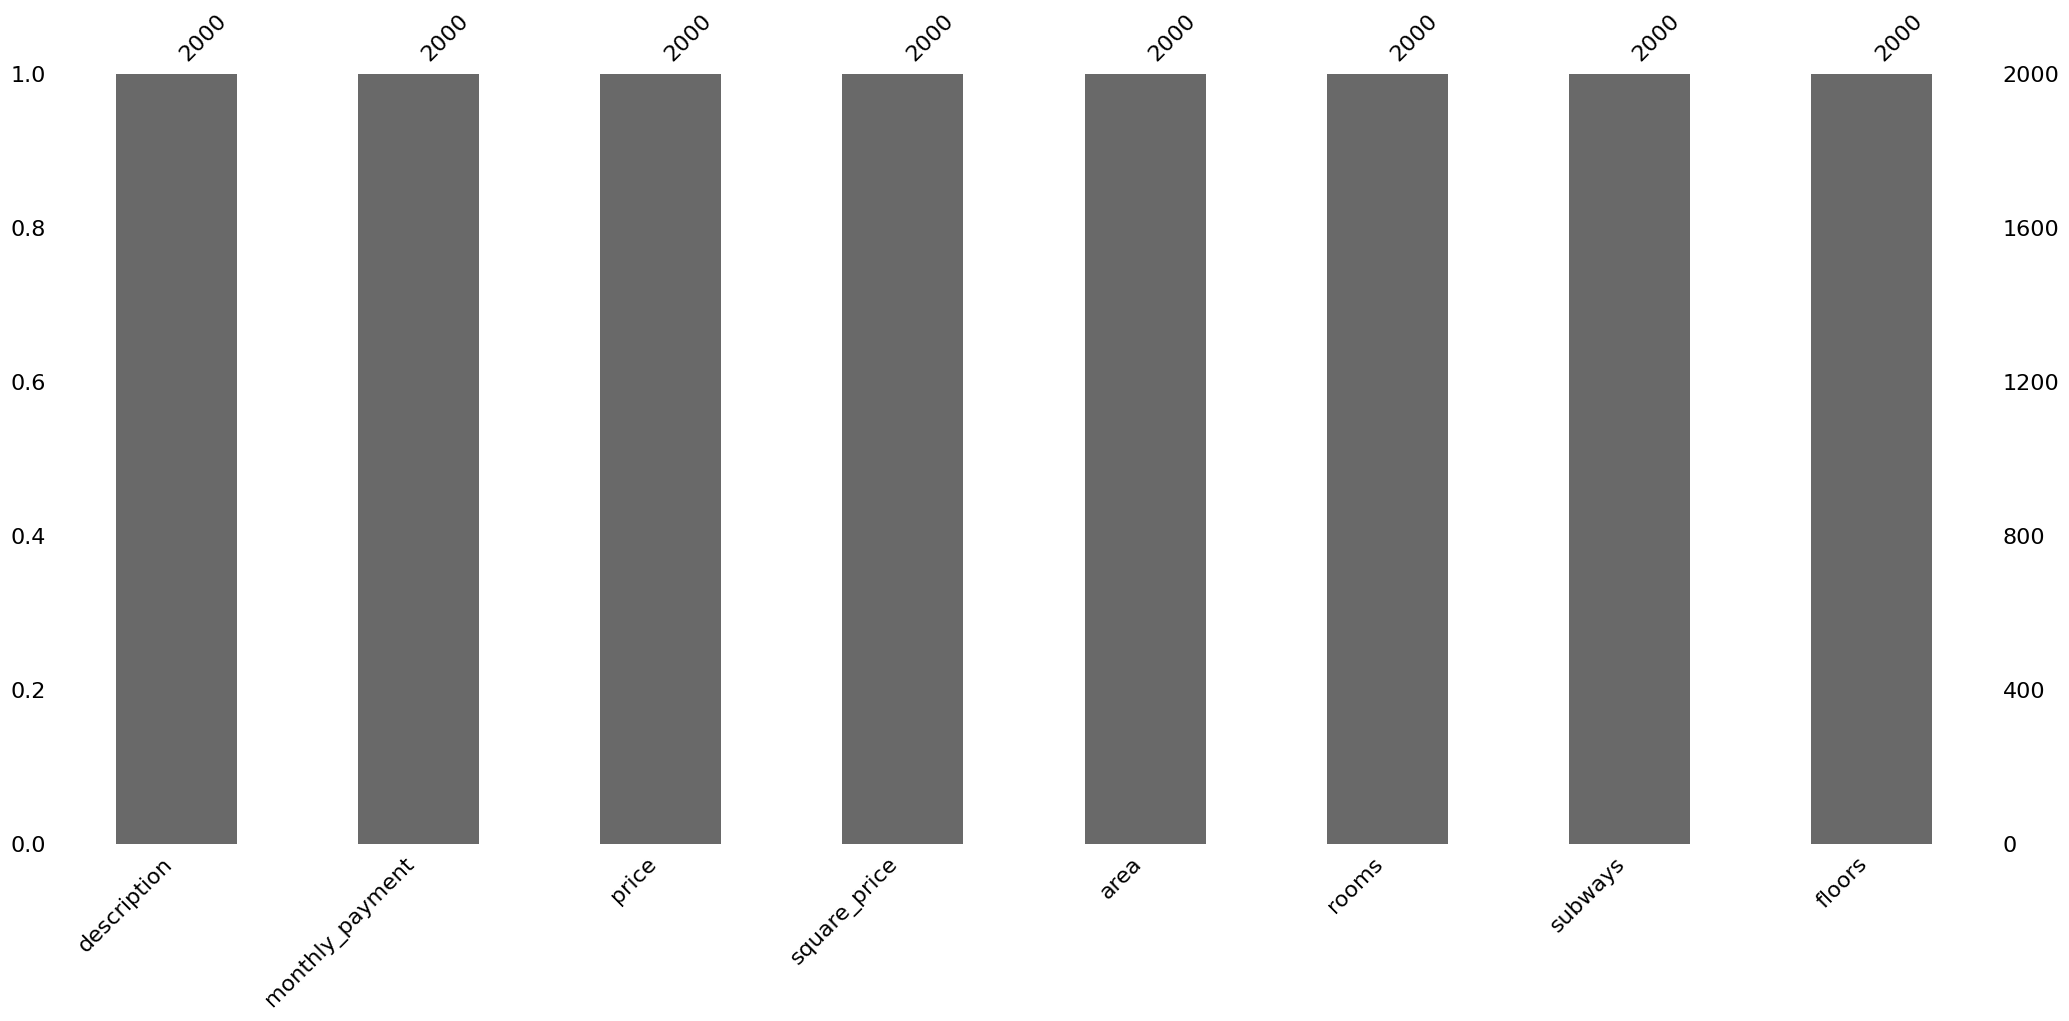

In [73]:
msno.bar(full)
plt.show()

In [74]:
missing_columns = [col for col in full.columns if full[col].isnull().sum() > 0]
missing_columns

[]

Построение графиков зависимости цены квдаратного метра от каждой колонки 

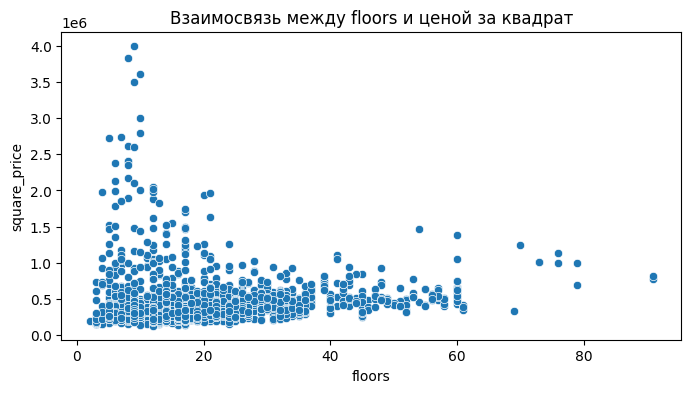

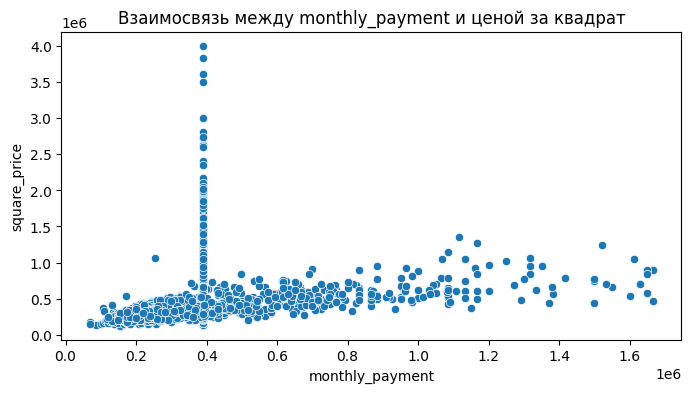

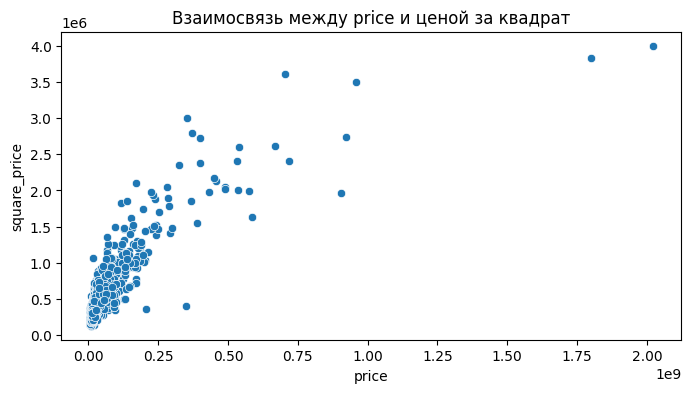

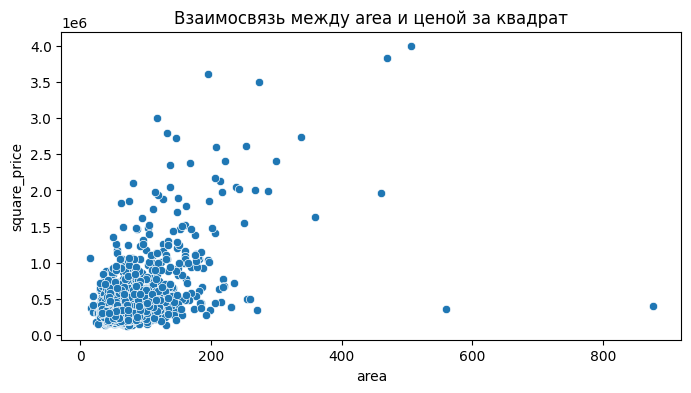

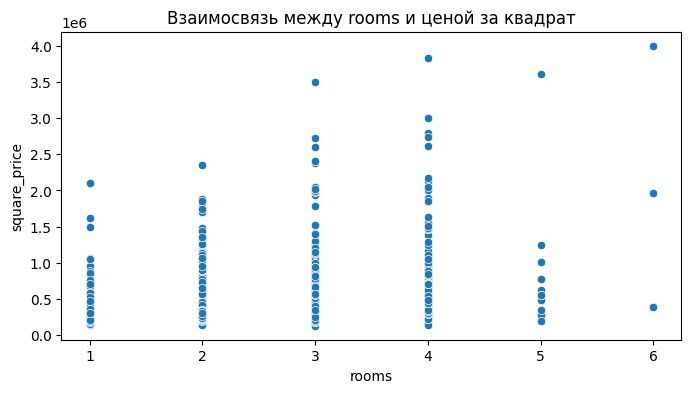

In [75]:
columns_to_plot = ['floors', 'monthly_payment', 'price', 'area', 'rooms']

for column in columns_to_plot:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=full, x=column, y='square_price')
    plt.title(f'Взаимосвязь между {column} и ценой за квадрат')
    plt.xlabel(column)
    plt.ylabel('square_price')
    plt.show()

Корреляционная матрица

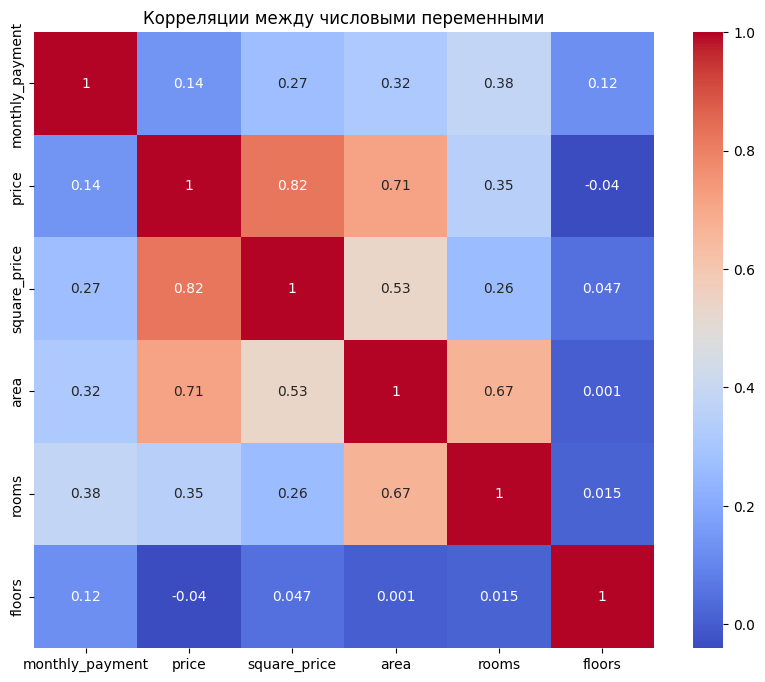

In [76]:
numeric_df = full.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляции между числовыми переменными')
plt.show()

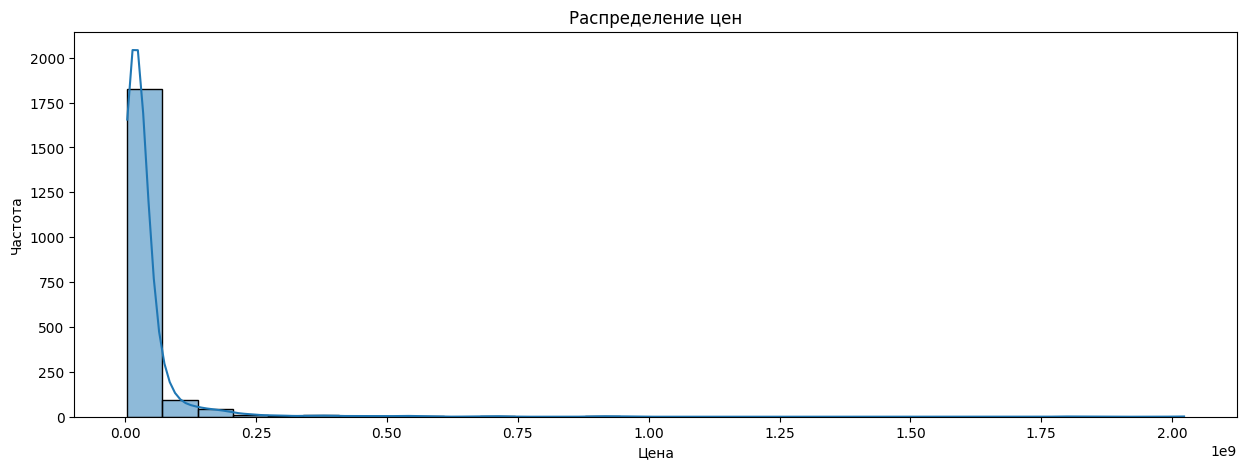

In [77]:
plt.figure(figsize=(15, 5))
sns.histplot(full['price'], bins=30, kde=True)
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

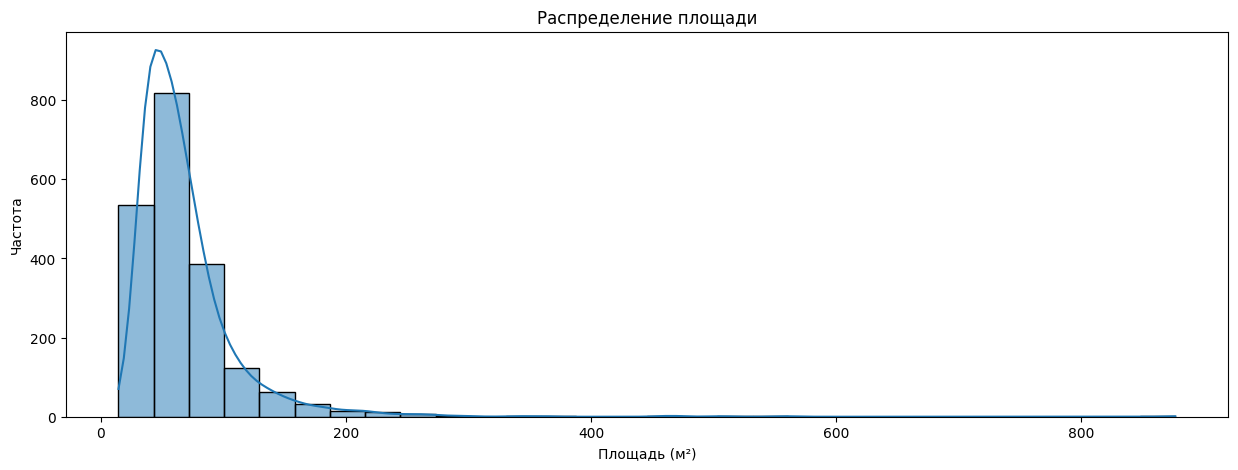

In [78]:
plt.figure(figsize=(15, 5))
sns.histplot(full['area'], bins=30, kde=True)
plt.title('Распределение площади')
plt.xlabel('Площадь (м²)')
plt.ylabel('Частота')
plt.show()

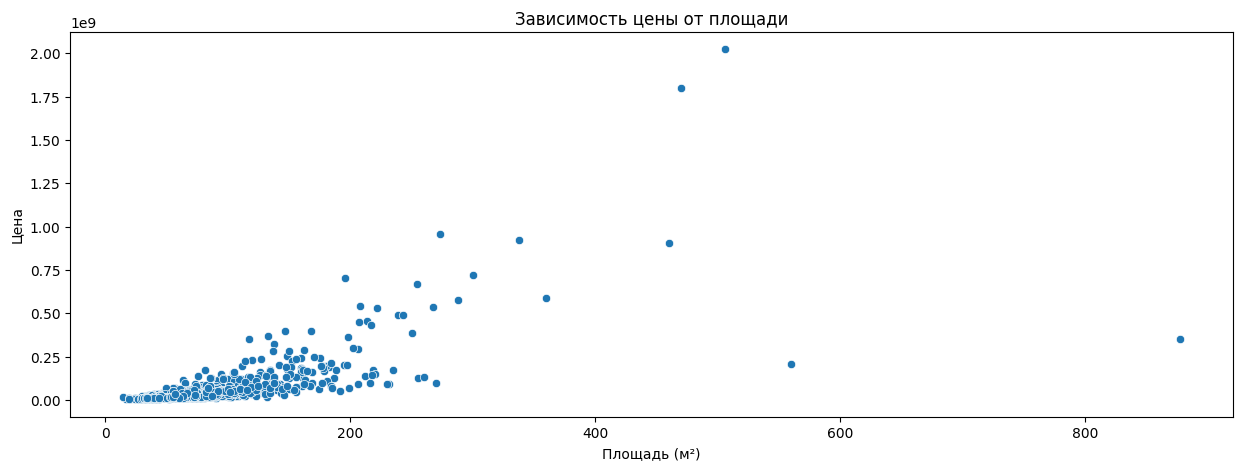

In [79]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data=full, x='area', y='price')
plt.title('Зависимость цены от площади')
plt.xlabel('Площадь (м²)')
plt.ylabel('Цена')
plt.show()


Закончили с анализом данных в коде

Экспортируем дата фрэйм во второй CSV файл для анализа в EXCEL

In [80]:
full.to_csv('pars_ready.csv', sep=',', index=False, encoding='utf-8')